## Project 

### Import Lib

In [1]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
#permet d'afficher toutes les lignes
#suppress -> chiffres en notation normal et pas en format scientifique
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

### Import data 

In [3]:
na_values = ['na']

In [4]:
data = pd.read_csv('./fbref/fbref_outfield_player_stats_combined_latest.csv', sep=',',na_values=na_values)

In [5]:
# Filtrage en gardant seulement championnat
data = data.loc[data["League Name"]!='Champions-League']
data = data.loc[data["League Name"]!='Europa-League']
data

Player   Nation    Pos         Squad   Age    Born  MP  \
0            Aaron Hunt   de GER  MF,FW  Hamburger SV  30.0  1986.0  28   
1          Abdou Diallo   sn SEN     DF      Mainz 05  21.0  1996.0  27   
2       Ademola Lookman  eng ENG  MF,FW    RB Leipzig  19.0  1997.0  11   
3         Admir Mehmedi   ch SUI  DF,MF    Leverkusen  26.0  1991.0  12   
4         Admir Mehmedi   ch SUI  FW,MF     Wolfsburg  26.0  1991.0   5   
...                 ...      ...    ...           ...   ...     ...  ..   
22957     Álvaro Morata   es ESP     FW      Juventus  29.0  1992.0  24   
22958  Álvaro Odriozola   es ESP     DF    Fiorentina  26.0  1995.0  19   
22959           Éderson   br BRA     MF   Salernitana  22.0  1999.0   1   
22960  Łukasz Skorupski   pl POL     GK       Bologna  30.0  1991.0  24   
22961       Ștefan Radu   ro ROU     DF         Lazio  35.0  1986.0   6   

       Starts     Min   90s  ...  PKwon  PKcon   OG  Recov   Won  Lost  Won%  \
0          26  2081.0  23.1  ...    0.0    0.0  0.0  213.0  22.0  37.0  37.3   
1          27  2415.0  26.8  ...    0.0    1.0  0.0  310.0  74.0  28.0  72.5   
2           7   574.0   6.4  ...    0.0    0.0  0.0   59.0   3.0   6.0  33.3   
3           8   700.0   7.8  ...    0.0    1.0  0.0   79.0  10.0   5.0  66.7   
4           3   290.0   3.2  ...    0.0    0.0  0.0   20.0   8.0   8.0  50.0   
...       ...     ...   ...  ...    ...    ...  ...    ...   ...   ...   ...   
22957      18  1596.0  17.7  ...    2.0    0.0  0.0   80.0  26.0  32.0  44.8   
22958      14  1325.0  14.7  ...    1.0    0.0  0.0   95.0   3.0  19.0  13.6   
22959       1    61.0   0.7  ...    0.0    0.0  0.0    6.0   1.0   2.0  33.3   
22960      24  2160.0  24.0  ...    0.0    1.0  0.0  104.0   0.0   0.0   NaN   
22961       3   326.0   3.6  ...    0.0    0.0  0.0   31.0  11.0   4.0  73.3   

       League Name  League ID     Season  
0       Bundesliga         20  2017-2018  
1       Bundesliga         20  2017-2018  
2       Bundesliga         20  2017-2018  
3       Bundesliga         20  2017-2018  
4       Bundesliga         20  2017-2018  
...            ...        ...        ...  
22957      Serie-A         11  2021-2022  
22958      Serie-A         11  2021-2022  
22959      Serie-A         11  2021-2022  
22960      Serie-A         11  2021-2022  
22961      Serie-A         11  2021-2022  

[13654 rows x 163 columns]

### Data preprocessing 

In [6]:
data['Nation'] = data['Nation'].astype('string')
data = data.dropna(subset=['Nation'])
data["Nation_new"] = data['Nation'].apply(lambda x: x[3:7])
data = data.drop(columns=['Nation'])

In [7]:
data["Nation_new"]

0         GER
1         SEN
2         ENG
3         SUI
4         SUI
         ... 
22957     ESP
22958     ESP
22959     BRA
22960     POL
22961     ROU
Name: Nation_new, Length: 13652, dtype: object

In [8]:
# Colonnes utiles
mycolumns = ['Player_id','Age','90s','CrdY','CrdR','Gls/90','Ast/90','xG/90','xA/90','Sh/90','SoT/90','Dist','FK','Cmp','Att',\
             'TotDist','PrgDist','Cmp_short','Att_short','Cmp_medium','Att_medium','Cmp_long','Att_long','KP','1/3','PPA',\
             'CrsPA','Prog','SCA90','PassLive','PassDead','Drib','Fld','Def','GCA90','PassLive_AMB','PassDead_AMB','Drib_AMB',\
            'Fld_AMB','Def_AMB','Tkl','TklW','Def 3rd','Mid 3rd','Att 3rd','Tkl_dribble','Past','Succ','Def 3rd_pression', \
             'Mid 3rd_pression','Att 3rd_pression','Touches','Def Pen','Att Pen','Carries','CPA','Fls']

In [9]:
data['Pos']

0        MF,FW
1           DF
2        MF,FW
3        DF,MF
4        FW,MF
         ...  
22957       FW
22958       DF
22959       MF
22960       GK
22961       DF
Name: Pos, Length: 13652, dtype: object

In [10]:
# recodage des modalités
data['Pos'] = data['Pos'].str.split(',')
data['Season'] = data['Season'].str.split('-')

In [11]:
data['Pos']

0        [MF, FW]
1            [DF]
2        [MF, FW]
3        [DF, MF]
4        [FW, MF]
           ...   
22957        [FW]
22958        [DF]
22959        [MF]
22960        [GK]
22961        [DF]
Name: Pos, Length: 13652, dtype: object

In [12]:
data['Pos'] = [elem[0] for elem in data['Pos']]
data['Season'] = [elem[1] for elem in data['Season']]

In [13]:
data['Pos']

0        MF
1        DF
2        MF
3        DF
4        FW
         ..
22957    FW
22958    DF
22959    MF
22960    GK
22961    DF
Name: Pos, Length: 13652, dtype: object

In [14]:
display(data['Pos'],
        data['Season'])

0        MF
1        DF
2        MF
3        DF
4        FW
         ..
22957    FW
22958    DF
22959    MF
22960    GK
22961    DF
Name: Pos, Length: 13652, dtype: object

0        2018
1        2018
2        2018
3        2018
4        2018
         ... 
22957    2022
22958    2022
22959    2022
22960    2022
22961    2022
Name: Season, Length: 13652, dtype: object

In [15]:
data['Player_id']=data['Player']+data['Season']

In [16]:
data['Player_id']

0              Aaron Hunt2018
1            Abdou Diallo2018
2         Ademola Lookman2018
3           Admir Mehmedi2018
4           Admir Mehmedi2018
                 ...         
22957       Álvaro Morata2022
22958    Álvaro Odriozola2022
22959             Éderson2022
22960    Łukasz Skorupski2022
22961         Ștefan Radu2022
Name: Player_id, Length: 13652, dtype: object

In [17]:
#

In [18]:
data_ok=data[mycolumns]
data_ok

Player_id   Age   90s  CrdY  CrdR  Gls/90  Ast/90  xG/90  \
0            Aaron Hunt2018  30.0  23.1     1     0    0.13    0.09   0.12   
1          Abdou Diallo2018  21.0  26.8     5     0    0.07    0.04   0.09   
2       Ademola Lookman2018  19.0   6.4     1     0    0.78    0.47   0.36   
3         Admir Mehmedi2018  26.0   7.8     3     0    0.26    0.39   0.14   
4         Admir Mehmedi2018  26.0   3.2     0     0    0.31    0.00   0.04   
...                     ...   ...   ...   ...   ...     ...     ...    ...   
22957     Álvaro Morata2022  29.0  17.7     4     0    0.28    0.06   0.26   
22958  Álvaro Odriozola2022  26.0  14.7     4     1    0.07    0.07   0.03   
22959           Éderson2022  22.0   0.7     0     0    0.00    0.00   0.00   
22960  Łukasz Skorupski2022  30.0  24.0     3     0    0.00    0.00   0.00   
22961       Ștefan Radu2022  35.0   3.6     1     0    0.00    0.00   0.02   

       xA/90  Sh/90  ...   Succ  Def 3rd_pression  Mid 3rd_pression  \
0       0.23   1.17  ...  135.0             102.0             261.0   
1       0.03   0.48  ...  144.0             219.0             109.0   
2       0.54   2.04  ...   30.0              17.0              48.0   
3       0.17   1.67  ...   29.0              32.0              69.0   
4       0.04   1.24  ...   18.0              19.0              24.0   
...      ...    ...  ...    ...               ...               ...   
22957   0.22   2.20  ...   87.0              35.0             123.0   
22958   0.17   0.20  ...   64.0              82.0              69.0   
22959   0.00   0.00  ...    4.0              10.0               4.0   
22960   0.00   0.00  ...    1.0               4.0               0.0   
22961   0.00   0.55  ...   11.0              11.0              17.0   

       Att 3rd_pression  Touches  Def Pen  Att Pen  Carries   CPA  Fls  
0                 121.0   1475.0     28.0     68.0    892.0   7.0   30  
1                  21.0   1496.0    118.0     24.0    866.0   1.0   57  
2                  24.0    312.0      6.0     30.0    270.0   7.0   13  
3                  24.0    519.0     10.0     27.0    340.0   5.0   21  
4                  11.0    158.0      4.0      4.0    102.0   1.0    5  
...                 ...      ...      ...      ...      ...   ...  ...  
22957             150.0    696.0     18.0     96.0    488.0  22.0   37  
22958              54.0    920.0     59.0     46.0    622.0  17.0   16  
22959               2.0     26.0      4.0      0.0     18.0   0.0    0  
22960               0.0    871.0    765.0      0.0    404.0   0.0    1  
22961               1.0    201.0     21.0      2.0    130.0   0.0    4  

[13652 rows x 57 columns]

In [19]:
#Données non normalisées
liste_90 = ['CrdY','CrdR','Dist','FK','Cmp','Att',\
             'TotDist','PrgDist','Cmp_short','Att_short','Cmp_medium','Att_medium','Cmp_long','Att_long','KP','1/3','PPA',\
             'CrsPA','Prog','PassLive','PassDead','Drib','Fld','Def','PassLive_AMB','PassDead_AMB','Drib_AMB',\
            'Fld_AMB','Def_AMB','Tkl','TklW','Def 3rd','Mid 3rd','Att 3rd','Tkl_dribble','Past','Succ','Def 3rd_pression', \
             'Mid 3rd_pression','Att 3rd_pression','Touches','Def Pen','Att Pen','Carries','CPA','Fls']

In [20]:
# Filtres sur les joueurs ayant + de 6 matchs 
data_ok_flt = data_ok.loc[data_ok['90s'] > 6]  

In [21]:
# Boucle pour normaliser les données (qui ne l'étaient pas)
for i in liste_90:
    data_ok_flt[str(i)]=data_ok_flt[str(i)]/data_ok_flt['90s']
del data_ok_flt['90s']
data_ok_flt

Player_id   Age      CrdY      CrdR  Gls/90  Ast/90  \
0              Aaron Hunt2018  30.0  0.043290  0.000000    0.13    0.09   
1            Abdou Diallo2018  21.0  0.186567  0.000000    0.07    0.04   
2         Ademola Lookman2018  19.0  0.156250  0.000000    0.78    0.47   
3           Admir Mehmedi2018  26.0  0.384615  0.000000    0.26    0.39   
6             Albin Ekdal2018  28.0  0.243902  0.000000    0.00    0.08   
...                       ...   ...       ...       ...     ...     ...   
22955    Zinho Vanheusden2022  22.0  0.272727  0.000000    0.00    0.00   
22956  Zlatan Ibrahimović2022  40.0  0.099010  0.000000    0.79    0.10   
22957       Álvaro Morata2022  29.0  0.225989  0.000000    0.28    0.06   
22958    Álvaro Odriozola2022  26.0  0.272109  0.068027    0.07    0.07   
22960    Łukasz Skorupski2022  30.0  0.125000  0.000000    0.00    0.00   

       xG/90  xA/90  Sh/90  SoT/90  ...      Succ  Def 3rd_pression  \
0       0.12   0.23   1.17    0.26  ...  5.844156          4.415584   
1       0.09   0.03   0.48    0.11  ...  5.373134          8.171642   
2       0.36   0.54   2.04    0.94  ...  4.687500          2.656250   
3       0.14   0.17   1.67    0.51  ...  3.717949          4.102564   
6       0.04   0.08   0.65    0.08  ...  6.991870          7.235772   
...      ...    ...    ...     ...  ...       ...               ...   
22955   0.01   0.01   0.55    0.18  ...  3.454545          6.000000   
22956   0.65   0.16   4.46    1.59  ...  3.366337          0.297030   
22957   0.26   0.22   2.20    0.96  ...  4.915254          1.977401   
22958   0.03   0.17   0.20    0.07  ...  4.353741          5.578231   
22960   0.00   0.00   0.00    0.00  ...  0.041667          0.166667   

       Mid 3rd_pression  Att 3rd_pression    Touches    Def Pen   Att Pen  \
0             11.298701          5.238095  63.852814   1.212121  2.943723   
1              4.067164          0.783582  55.820896   4.402985  0.895522   
2              7.500000          3.750000  48.750000   0.937500  4.687500   
3              8.846154          3.076923  66.538462   1.282051  3.461538   
6              9.430894          1.626016  56.260163   2.764228  1.300813   
...                 ...               ...        ...        ...       ...   
22955          3.545455          0.818182  48.727273   8.363636  1.000000   
22956          2.376238          6.237624  48.613861   1.287129  8.217822   
22957          6.949153          8.474576  39.322034   1.016949  5.423729   
22958          4.693878          3.673469  62.585034   4.013605  3.129252   
22960          0.000000          0.000000  36.291667  31.875000  0.000000   

         Carries       CPA       Fls  
0      38.614719  0.303030  1.298701  
1      32.313433  0.037313  2.126866  
2      42.187500  1.093750  2.031250  
3      43.589744  0.641026  2.692308  
6      34.308943  0.081301  1.382114  
...          ...       ...       ...  
22955  27.181818  0.090909  1.454545  
22956  29.108911  0.396040  1.386139  
22957  27.570621  1.242938  2.090395  
22958  42.312925  1.156463  1.088435  
22960  16.833333  0.000000  0.041667  

[9181 rows x 56 columns]

### Traitement des NaN

In [22]:
data_ok_flt.isna().sum(axis = 0)

Player_id             0
Age                   0
CrdY                  0
CrdR                  0
Gls/90                0
Ast/90                0
xG/90                 0
xA/90                 0
Sh/90                 0
SoT/90                0
Dist                684
FK                    0
Cmp                   0
Att                   0
TotDist               0
PrgDist               0
Cmp_short             0
Att_short             0
Cmp_medium            0
Att_medium            0
Cmp_long              0
Att_long              0
KP                    0
1/3                   0
PPA                   0
CrsPA                 0
Prog                  0
SCA90                 0
PassLive              0
PassDead              0
Drib                  0
Fld                   0
Def                   0
GCA90                 0
PassLive_AMB          0
PassDead_AMB          0
Drib_AMB              0
Fld_AMB               0
Def_AMB               0
Tkl                   0
TklW                  0
Def 3rd         

In [23]:
data_ok_flt=data_ok_flt.drop(columns=['Dist'])

In [24]:
data_ok_flt.to_csv('data_ok_flt')

In [25]:
data_ok_flt

Player_id   Age      CrdY      CrdR  Gls/90  Ast/90  \
0              Aaron Hunt2018  30.0  0.043290  0.000000    0.13    0.09   
1            Abdou Diallo2018  21.0  0.186567  0.000000    0.07    0.04   
2         Ademola Lookman2018  19.0  0.156250  0.000000    0.78    0.47   
3           Admir Mehmedi2018  26.0  0.384615  0.000000    0.26    0.39   
6             Albin Ekdal2018  28.0  0.243902  0.000000    0.00    0.08   
...                       ...   ...       ...       ...     ...     ...   
22955    Zinho Vanheusden2022  22.0  0.272727  0.000000    0.00    0.00   
22956  Zlatan Ibrahimović2022  40.0  0.099010  0.000000    0.79    0.10   
22957       Álvaro Morata2022  29.0  0.225989  0.000000    0.28    0.06   
22958    Álvaro Odriozola2022  26.0  0.272109  0.068027    0.07    0.07   
22960    Łukasz Skorupski2022  30.0  0.125000  0.000000    0.00    0.00   

       xG/90  xA/90  Sh/90  SoT/90  ...      Succ  Def 3rd_pression  \
0       0.12   0.23   1.17    0.26  ...  5.844156          4.415584   
1       0.09   0.03   0.48    0.11  ...  5.373134          8.171642   
2       0.36   0.54   2.04    0.94  ...  4.687500          2.656250   
3       0.14   0.17   1.67    0.51  ...  3.717949          4.102564   
6       0.04   0.08   0.65    0.08  ...  6.991870          7.235772   
...      ...    ...    ...     ...  ...       ...               ...   
22955   0.01   0.01   0.55    0.18  ...  3.454545          6.000000   
22956   0.65   0.16   4.46    1.59  ...  3.366337          0.297030   
22957   0.26   0.22   2.20    0.96  ...  4.915254          1.977401   
22958   0.03   0.17   0.20    0.07  ...  4.353741          5.578231   
22960   0.00   0.00   0.00    0.00  ...  0.041667          0.166667   

       Mid 3rd_pression  Att 3rd_pression    Touches    Def Pen   Att Pen  \
0             11.298701          5.238095  63.852814   1.212121  2.943723   
1              4.067164          0.783582  55.820896   4.402985  0.895522   
2              7.500000          3.750000  48.750000   0.937500  4.687500   
3              8.846154          3.076923  66.538462   1.282051  3.461538   
6              9.430894          1.626016  56.260163   2.764228  1.300813   
...                 ...               ...        ...        ...       ...   
22955          3.545455          0.818182  48.727273   8.363636  1.000000   
22956          2.376238          6.237624  48.613861   1.287129  8.217822   
22957          6.949153          8.474576  39.322034   1.016949  5.423729   
22958          4.693878          3.673469  62.585034   4.013605  3.129252   
22960          0.000000          0.000000  36.291667  31.875000  0.000000   

         Carries       CPA       Fls  
0      38.614719  0.303030  1.298701  
1      32.313433  0.037313  2.126866  
2      42.187500  1.093750  2.031250  
3      43.589744  0.641026  2.692308  
6      34.308943  0.081301  1.382114  
...          ...       ...       ...  
22955  27.181818  0.090909  1.454545  
22956  29.108911  0.396040  1.386139  
22957  27.570621  1.242938  2.090395  
22958  42.312925  1.156463  1.088435  
22960  16.833333  0.000000  0.041667  

[9181 rows x 55 columns]

In [26]:
#Séparation des variables 
X = data_ok_flt.drop(['Player_id'], axis=1)

In [27]:
# Categorical variable
X_cat = data_ok_flt[['Player_id']]

In [28]:
X_cat

Player_id
0              Aaron Hunt2018
1            Abdou Diallo2018
2         Ademola Lookman2018
3           Admir Mehmedi2018
6             Albin Ekdal2018
...                       ...
22955    Zinho Vanheusden2022
22956  Zlatan Ibrahimović2022
22957       Álvaro Morata2022
22958    Álvaro Odriozola2022
22960    Łukasz Skorupski2022

[9181 rows x 1 columns]

In [29]:
X.columns

Index(['Age', 'CrdY', 'CrdR', 'Gls/90', 'Ast/90', 'xG/90', 'xA/90', 'Sh/90',
       'SoT/90', 'FK', 'Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp_short',
       'Att_short', 'Cmp_medium', 'Att_medium', 'Cmp_long', 'Att_long', 'KP',
       '1/3', 'PPA', 'CrsPA', 'Prog', 'SCA90', 'PassLive', 'PassDead', 'Drib',
       'Fld', 'Def', 'GCA90', 'PassLive_AMB', 'PassDead_AMB', 'Drib_AMB',
       'Fld_AMB', 'Def_AMB', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd',
       'Tkl_dribble', 'Past', 'Succ', 'Def 3rd_pression', 'Mid 3rd_pression',
       'Att 3rd_pression', 'Touches', 'Def Pen', 'Att Pen', 'Carries', 'CPA',
       'Fls'],
      dtype='object')

In [30]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer,KNNImputer

In [31]:
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_new = imp_num.fit_transform(X)
X_new = StandardScaler().fit_transform(X_new)

### Choix du nombre de clusters avec WCSS

In [32]:
wcss = []
K = range(1, 12)
for k in K:
  km = KMeans(n_clusters = k)
  km = km.fit(X_new)
  wcss.append(km.inertia_)

In [33]:
wcss

[495774.0000000003,
 389636.3104051695,
 330038.5669010489,
 300087.49687201786,
 275064.08829562867,
 256850.0300117093,
 247771.02004345253,
 238298.30755587431,
 230585.33769703042,
 223439.4749811191,
 218677.65855410998]

In [34]:
plt.plot(K, wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal k');

### PCA (Principal Component Analisys)

In [35]:
pca = PCA(n_components=0.8)
df_pca = pca.fit_transform(X_new)

In [36]:
df_pca

array([[ 2.72746156,  2.56779806,  2.93788967, ..., -1.37943064,
        -0.28993099,  0.63958586],
       [-2.47475685,  0.73818068, -1.65150635, ..., -0.36872866,
         0.57426013,  0.0987539 ],
       [10.23273999, -0.21131684,  4.57119784, ..., -0.95559812,
         2.21531436, -2.0821419 ],
       ...,
       [ 5.92128406, -3.26806165,  0.37401155, ...,  0.69729764,
        -0.88830451, -1.20669194],
       [ 0.2148688 ,  1.63189732,  1.09640176, ...,  1.8022861 ,
        -0.95111156,  0.62071908],
       [-5.56606898, -6.69848777,  2.91312795, ...,  0.10877734,
        -0.23058407, -0.69115122]])

In [37]:
X_new.shape

(9181, 54)

In [38]:
df_pca.shape

(9181, 10)

In [39]:
pca.explained_variance_ratio_

array([0.27973933, 0.23473249, 0.10619929, 0.04612346, 0.0326519 ,
       0.0255597 , 0.02366805, 0.02104615, 0.01930561, 0.01847875])

In [40]:
exp_var = [round(i, 1) for i in pca.explained_variance_ratio_ * 100]

In [41]:
exp_var

[28.0, 23.5, 10.6, 4.6, 3.3, 2.6, 2.4, 2.1, 1.9, 1.8]

In [42]:
summ=0
for i in exp_var:
    summ=summ+i

In [43]:
summ

80.8

### Choix du nombre de clusters avec la méthode de la silhouette

 https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

For n_clusters =  2  Average score:  0.226683302129993
For n_clusters =  3  Average score:  0.18592091673165334
For n_clusters =  4  Average score:  0.21632938060780657
For n_clusters =  5  Average score:  0.18139363867648714
For n_clusters =  6  Average score:  0.17541678539646235
For n_clusters =  7  Average score:  0.15755308123620237
For n_clusters =  8  Average score:  0.14966332463496937
For n_clusters =  9  Average score:  0.1501766376268315
For n_clusters =  10  Average score:  0.14866657327264113
For n_clusters =  11  Average score:  0.14785784539495822


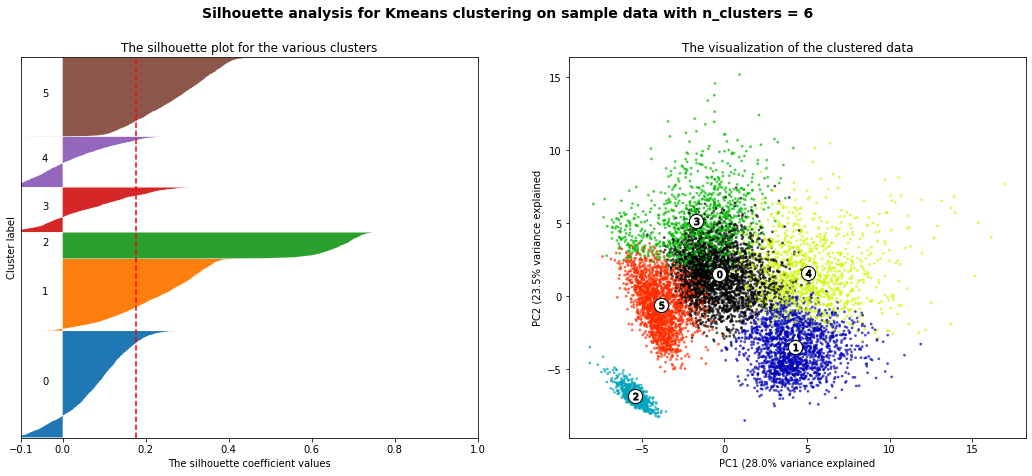

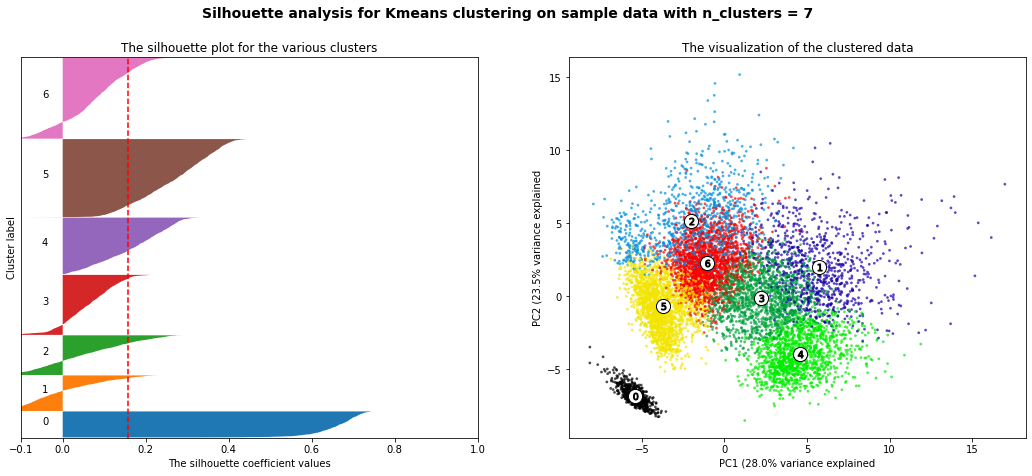

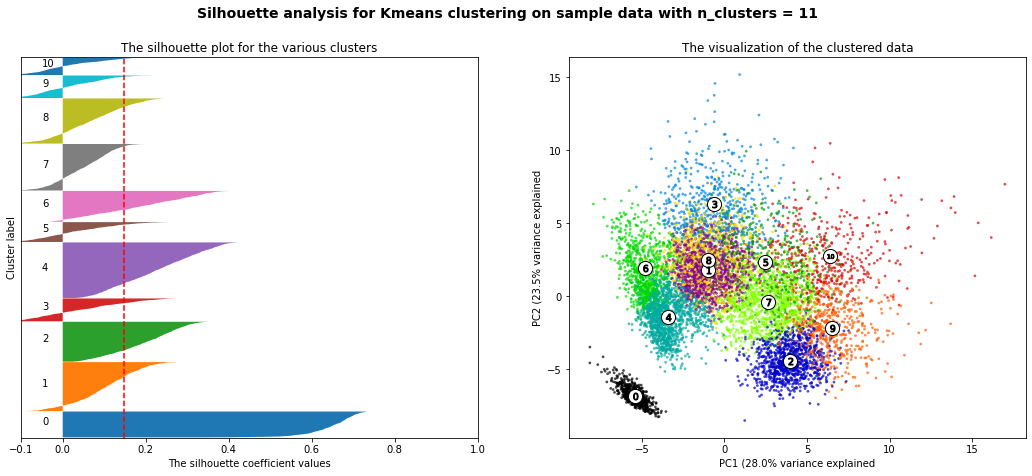

In [44]:
range_n_clusters = range(2, 12)
for n_clusters in range_n_clusters:
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, len(X_new) + (n_clusters + 1) * 10])

  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict(X_new)
  #print(cluster_labels)
  #print(np.unique(cluster_labels))

  silhouette_avg = silhouette_score(X_new, cluster_labels)
  print("For n_clusters = ", n_clusters, " Average score: ", silhouette_avg)

  sample_silhouette_values = silhouette_samples(X_new, cluster_labels)
  #print(sample_silhouette_values)
  #print(len(sample_silhouette_values))

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    #print(ith_cluster_silhouette_values.shape)

    size_cluster_i = ith_cluster_silhouette_values.shape[0]

    y_upper = y_lower + size_cluster_i
    #print(y_upper)

    ax1.fill_betweenx(np.arange(y_lower, y_upper), ith_cluster_silhouette_values)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

  ax1.set_title("The silhouette plot for the various clusters")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")   

  ax1.axvline(x = silhouette_avg, color = "red", linestyle = "--")

  ax1.set_yticks([])
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(df_pca[:, 0], df_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

  centers = clusterer.cluster_centers_
  centers = pca.transform(centers)
  ax2.scatter(centers[:, 0], centers[:,1], marker='o', c='white', alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, s=50, edgecolor='k')

  ax2.set_title("The visualization of the clustered data")
  ax2.set_xlabel('PC1 (' + str(exp_var[0]) + '% variance explained')
  ax2.set_ylabel('PC2 (' + str(exp_var[1]) + '% variance explained')

  plt.suptitle(("Silhouette analysis for Kmeans clustering on sample data with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

### Application k-means

In [45]:
import matplotlib
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_new)
clustering=kmeans.labels_
colors = ['red','yellow','blue','pink','green']
plt.figure(figsize=(16,12))
plt.grid(True,which="both", linestyle='--')
plt.scatter(df_pca[:, 0], df_pca[:, 1], c= clustering, cmap=matplotlib.colors.ListedColormap(colors))
#for label, x, y in zip(labels, X_pca[:, 0], X_pca[:, 1]):
    #plt.annotate(label, xy=(x, y), xytext=(-0.2, 0.2), textcoords='offset points')
plt.show()

In [46]:
km = KMeans(n_clusters=4, n_init=100, random_state=0)
km.fit(X_new)

KMeans(n_clusters=4, n_init=100, random_state=0)

In [47]:
print(km.cluster_centers_)

[[ 0.54267988 -1.03049343 -0.23823771 -0.72091437 -0.80294634 -0.843271
  -1.03086182 -1.18403849 -0.95969604 -0.37757483 -0.87149743 -0.77710245
   0.10665191  1.77261461 -1.62098926 -1.8021637  -0.71523788 -0.97842134
   1.26966537  2.01774719 -1.19333637 -1.23663847 -1.14914523 -0.79390973
  -1.72018712 -1.3665435  -1.43263446 -0.42089881 -0.69646029 -0.78172077
  -0.69213734 -0.98733976 -0.93139422 -0.28955522 -0.3801034  -0.4367299
  -0.25240557 -1.76930265 -1.68973358 -1.40632071 -1.47487237 -1.14924753
  -1.42191175 -1.54736044 -2.22136726 -1.72364964 -1.70996781 -1.15501845
  -1.27897527  3.29477739 -1.07804501 -1.45349456 -0.75513579 -1.82776213]
 [-0.15862947 -0.19939768 -0.08837931  0.97561698  0.39353818  1.13278331
   0.52556479  1.11252053  1.11677907  0.12148961 -0.94324508 -0.98881806
  -1.10501016 -1.11543168 -0.41220774 -0.3095817  -1.00331958 -0.99615971
  -1.01252808 -0.99945132  0.43602835 -0.70956277  0.21598137  0.03155443
  -0.51983874  0.59328536  0.50671276 -0

In [48]:
print(km.labels_)

[3 2 1 3 2 2 1 2 0 3 1 1 2 1 2 1 1 1 1 1 3 2 3 3 3 2 2 2 1 2 0 1 1 1 1 2 1
 3 1 2 3 0 1 2 1 3 2 2 3 3 1 1 2 3 3 2 3 1 2 2 2 2 2 3 1 2 3 2 2 1 3 2 1 2
 2 2 1 1 1 2 3 1 1 3 1 2 2 1 2 2 3 1 2 2 2 2 2 1 1 3 1 3 2 1 1 2 2 2 1 2 2
 2 2 3 1 0 2 3 1 2 2 3 1 2 2 3 1 1 2 2 3 2 3 2 0 2 2 3 1 3 1 2 1 3 2 2 3 2
 1 2 1 0 2 2 2 2 2 1 3 3 1 2 1 1 1 1 1 1 1 2 1 2 2 2 3 0 3 2 2 2 2 2 3 1 3
 3 2 2 2 2 2 1 1 2 1 1 1 3 3 1 1 2 1 2 0 1 2 2 2 2 2 3 2 3 1 1 1 1 3 2 1 1
 3 2 3 2 3 3 3 2 1 2 3 2 2 2 2 2 1 3 2 0 2 2 2 2 2 1 2 2 1 2 2 2 2 2 2 3 0
 1 3 0 1 3 0 2 2 3 1 0 2 2 2 1 2 2 1 0 0 0 0 2 2 1 1 1 2 2 3 1 1 1 3 2 1 1
 1 2 2 2 2 3 1 2 0 1 1 1 2 3 2 2 3 1 1 2 0 1 2 2 2 1 1 2 2 3 2 2 2 3 2 2 2
 0 2 1 1 1 1 1 3 1 2 2 2 3 2 3 2 1 3 1 2 2 1 2 2 0 0 3 2 1 1 2 1 2 0 1 1 2
 1 1 1 2 3 3 1 2 2 2 1 3 1 3 1 3 3 2 0 1 2 1 2 2 3 3 3 1 3 2 2 3 1 3 1 2 2
 2 3 1 2 2 3 1 3 2 3 1 2 2 0 2 2 2 2 3 1 3 0 1 1 3 2 2 2 2 3 0 1 1 1 2 3 1
 1 1 3 3 3 3 1 2 3 3 2 1 2 2 3 1 0 1 1 2 3 3 2 3 1 2 3 3 1 2 2 3 3 2 2 2 1
 2 2 3 1 1 2 2 1 3 2 2 3 

In [49]:
len(km.labels_)

9181

In [50]:
km.labels_

array([3, 2, 1, 3, 2, 2, 1, 2, 0, 3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 3, 2,
       3, 3, 3, 2, 2, 2, 1, 2, 0, 1, 1, 1, 1, 2, 1, 3, 1, 2, 3, 0, 1, 2,
       1, 3, 2, 2, 3, 3, 1, 1, 2, 3, 3, 2, 3, 1, 2, 2, 2, 2, 2, 3, 1, 2,
       3, 2, 2, 1, 3, 2, 1, 2, 2, 2, 1, 1, 1, 2, 3, 1, 1, 3, 1, 2, 2, 1,
       2, 2, 3, 1, 2, 2, 2, 2, 2, 1, 1, 3, 1, 3, 2, 1, 1, 2, 2, 2, 1, 2,
       2, 2, 2, 3, 1, 0, 2, 3, 1, 2, 2, 3, 1, 2, 2, 3, 1, 1, 2, 2, 3, 2,
       3, 2, 0, 2, 2, 3, 1, 3, 1, 2, 1, 3, 2, 2, 3, 2, 1, 2, 1, 0, 2, 2,
       2, 2, 2, 1, 3, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 0,
       3, 2, 2, 2, 2, 2, 3, 1, 3, 3, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 3,
       3, 1, 1, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 3, 2, 3, 1, 1, 1, 1, 3, 2,
       1, 1, 3, 2, 3, 2, 3, 3, 3, 2, 1, 2, 3, 2, 2, 2, 2, 2, 1, 3, 2, 0,
       2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 3, 0, 1, 3, 0, 1, 3,
       0, 2, 2, 3, 1, 0, 2, 2, 2, 1, 2, 2, 1, 0, 0, 0, 0, 2, 2, 1, 1, 1,
       2, 2, 3, 1, 1, 1, 3, 2, 1, 1, 1, 2, 2, 2, 2,

In [51]:
name=['Age','CrdY', 'CrdR', 'Gls/90', 'Ast/90', 'xG/90', 'xA/90', 'Sh/90', 'SoT/90',
       'FK', 'Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp_short', 'Att_short',
       'Cmp_medium', 'Att_medium', 'Cmp_long', 'Att_long', 'KP', '1/3', 'PPA',
       'CrsPA', 'Prog', 'SCA90', 'PassLive', 'PassDead', 'Drib', 'Fld', 'Def',
       'GCA90', 'PassLive_AMB', 'PassDead_AMB', 'Drib_AMB', 'Fld_AMB',
       'Def_AMB', 'Tkl', 'TklW', 'Def 3rd', 'Mid 3rd', 'Att 3rd',
       'Tkl_dribble', 'Past', 'Succ', 'Def 3rd_pression', 'Mid 3rd_pression',
       'Att 3rd_pression', 'Touches', 'Def Pen', 'Att Pen', 'Carries', 'CPA',
       'Fls','Group']

In [52]:
name

['Age',
 'CrdY',
 'CrdR',
 'Gls/90',
 'Ast/90',
 'xG/90',
 'xA/90',
 'Sh/90',
 'SoT/90',
 'FK',
 'Cmp',
 'Att',
 'TotDist',
 'PrgDist',
 'Cmp_short',
 'Att_short',
 'Cmp_medium',
 'Att_medium',
 'Cmp_long',
 'Att_long',
 'KP',
 '1/3',
 'PPA',
 'CrsPA',
 'Prog',
 'SCA90',
 'PassLive',
 'PassDead',
 'Drib',
 'Fld',
 'Def',
 'GCA90',
 'PassLive_AMB',
 'PassDead_AMB',
 'Drib_AMB',
 'Fld_AMB',
 'Def_AMB',
 'Tkl',
 'TklW',
 'Def 3rd',
 'Mid 3rd',
 'Att 3rd',
 'Tkl_dribble',
 'Past',
 'Succ',
 'Def 3rd_pression',
 'Mid 3rd_pression',
 'Att 3rd_pression',
 'Touches',
 'Def Pen',
 'Att Pen',
 'Carries',
 'CPA',
 'Fls',
 'Group']

In [53]:
data_final = pd.DataFrame(np.concatenate((X_new,km.labels_.reshape((-1,1))),axis=1),columns=name)

In [54]:
X_cat=X_cat.reset_index(drop=True)
data_final['Player']=X_cat
data_final

Age      CrdY      CrdR    Gls/90    Ast/90     xG/90     xA/90  \
0     0.947419 -1.070855 -0.344930  0.031937  0.048049 -0.043372  1.865077   
1    -1.242229 -0.030225 -0.344930 -0.319707 -0.437036 -0.245504 -0.678733   
2    -1.728818 -0.250420 -0.344930  3.841415  3.734697  1.573686  5.807983   
3    -0.025758  1.408211 -0.344930  0.793832  2.958560  0.091383  1.101934   
4     0.460831  0.386205 -0.344930 -0.729959 -0.048968 -0.582391 -0.042780   
...        ...       ...       ...       ...       ...       ...       ...   
9176 -0.998935  0.595561 -0.344930 -0.729959 -0.825105 -0.784524 -0.933114   
9177  3.380363 -0.666158 -0.344930  3.900022  0.145066  3.527630  0.974744   
9178  0.704125  0.256096 -0.344930  0.911047 -0.243002  0.899911  1.737887   
9179 -0.025758  0.591070  2.060215 -0.319707 -0.145985 -0.649769  1.101934   
9180  0.947419 -0.477391 -0.344930 -0.729959 -0.825105 -0.851901 -1.060304   

         Sh/90    SoT/90        FK  ...  Mid 3rd_pression  Att 3rd_pression  \
0     0.006323 -0.318022  3.315749  ...          1.262228          0.728380   
1    -0.702709 -0.691902 -0.386164  ...         -0.646625         -0.874634   
2     0.900318  1.376903  0.949996  ...          0.259514          0.192869   
3     0.520113  0.305112  0.710172  ...          0.614848         -0.049346   
4    -0.528020 -0.766678 -0.386164  ...          0.769197         -0.571473   
...        ...       ...       ...  ...               ...               ...   
9176 -0.630778 -0.517425 -0.386164  ...         -0.784337         -0.862183   
9177  3.387066  2.997052  3.847212  ...         -1.092966          1.088073   
9178  1.064732  1.426754 -0.386164  ...          0.114111          1.893069   
9179 -0.990431 -0.791604 -0.386164  ...         -0.481197          0.165329   
9180 -1.195948 -0.966081 -0.386164  ...         -1.720203         -1.156616   

       Touches   Def Pen   Att Pen   Carries       CPA       Fls  Group  \
0     0.557620 -0.522920  0.421419  0.240585 -0.120490 -0.045109    3.0   
1     0.043112 -0.096347 -0.629452 -0.251448 -0.677222  1.124615    2.0   
2    -0.409835 -0.559633  1.316099  0.519564  1.536232  0.989564    1.0   
3     0.729657 -0.513571  0.687094  0.629058  0.587681  1.923262    3.0   
4     0.071251 -0.315426 -0.421509 -0.095629 -0.585059  0.072705    2.0   
...        ...       ...       ...       ...       ...       ...    ...   
9176 -0.411291  0.433134 -0.575848 -0.652147 -0.564928  0.175010    2.0   
9177 -0.418556 -0.512892  3.127401 -0.501671  0.074384  0.078390    1.0   
9178 -1.013771 -0.549011  1.693836 -0.621788  1.848812  1.073103    1.0   
9179  0.476409 -0.148402  0.516608  0.529358  1.667628 -0.342095    3.0   
9180 -1.207890  3.576263 -1.088918 -1.460204 -0.755401 -1.820582    0.0   

                      Player  
0             Aaron Hunt2018  
1           Abdou Diallo2018  
2        Ademola Lookman2018  
3          Admir Mehmedi2018  
4            Albin Ekdal2018  
...                      ...  
9176    Zinho Vanheusden2022  
9177  Zlatan Ibrahimović2022  
9178       Álvaro Morata2022  
9179    Álvaro Odriozola2022  
9180    Łukasz Skorupski2022  

[9181 rows x 56 columns]

In [56]:
data_final[data_final.Group==1]['Player']

2          Ademola Lookman2018
6        Alexander Esswein2018
10      Alfreð Finnbogason2018
11             Amine Harit2018
13        Anastasios Donis2018
                 ...          
9165        Victor Osimhen2022
9174          Yayah Kallon2022
9175         Youssef Maleh2022
9177    Zlatan Ibrahimović2022
9178         Álvaro Morata2022
Name: Player, Length: 2536, dtype: object

## Comparaison de plusieurs Classifieurs 

In [ ]:
## Comparaison de plusieurs Classifieurs 

from sklearn.model_selection import KFold,cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.model_selection import KFold,cross_val_score
import time

clfs = {
    'RF': RandomForestClassifier(n_estimators=100, random_state=1), 
    'ADA': AdaBoostClassifier(n_estimators=100,random_state=1),
    'ET': ExtraTreesClassifier(n_estimators=100,random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'CART': DecisionTreeClassifier(criterion='gini',random_state=1),
    'ID3': DecisionTreeClassifier(criterion='entropy',random_state=1),
    'Stumb': DecisionTreeClassifier(criterion='gini',max_depth=1,random_state=1),
    'MLP': MLPClassifier(hidden_layer_sizes=(20,10),random_state=1),
    'XGB': xgb.XGBClassifier(n_estimators=100,random_state=1,colsample_bytree=0.95,max_depth=4,verbosity=0)
}

def run_classifieurs(X,Y,clfs):
    kf = KFold(n_splits=10, shuffle=True, random_state=1) 
    for i in clfs:
        clf = clfs[i]
        debut=time.time()
        cv_acc = cross_val_score(clf, X, Y, cv=kf,scoring='accuracy')
        fin=time.time()
        print("Accuracy for {0} is: {1:.3f} +/- {2:.3f} en {3:.3f}s".format(i,
                                                                            np.mean(cv_acc),
                                                                            np.std(cv_acc),fin-debut))

In [ ]:
X_for_predict = data_final.iloc[:, 0:54].values
Y_for_predict = data_final.iloc[:, 54].values

### Run classifieurs

In [ ]:
run_classifieurs(X_for_predict,Y_for_predict,clfs)

### Création de pipeline

In [ ]:
from sklearn.pipeline import Pipeline
import pickle

In [ ]:
P=Pipeline([('SS',StandardScaler()),
            ('classifieur',MLPClassifier(hidden_layer_sizes=(20,10),random_state=1))])
P.fit(X_for_predict,Y_for_predict)

pickle.dump(P,open('Foot_clfs_players_MLP.pkl','wb'))